# Imports

In [37]:
import sys
import pathlib
import joblib
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

if pathlib.Path().parent.resolve().absolute().as_posix() not in sys.path:
    sys.path.append(pathlib.Path().parent.resolve().absolute().as_posix())

from pilot import Pilot, ensemble

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
DATAPATH = pathlib.Path().absolute() / 'Data'
datasets = {
    'abalone': {'categorical': [0]}, # sex
    'airfoil': {'categorical': [-1]},
    'Bias_correction_ucl': {'categorical': [0]}, # station 
    'bodyfat_preprocessed': {'categorical': [-1]},
    'boston': {'categorical': [3]}, # Charles river dummy
    'communities': {'categorical': [-1]}, # 119 = LemasGangUnitDeploy
    'concrete': {'categorical': [-1]},
    'diabetes': {'categorical': [-1]},
    'electricity': {'categorical': [-1]},
    'energy': {'categorical': [5]}, # Orientation (X6)
    'ga_preprocessed': {'categorical': [6]}, # Research
    'housing': {'categorical': [-1]},
    'ozone_preprocessed': {'categorical': [10, 11]},
    'residential': {'categorical': [-1]},
    'ribo_preprocessed': {'categorical': [-1]},
    'SeoulBikeData': {'categorical': [-1]}, # 10 = seasons
    'skills': {'categorical': [-1]},
    'superconductor': {'categorical': [-1]},
    'Walmart_preprocessed': {'categorical': [0]},
    'wine': {'categorical': [-1]}
}

In [3]:
for d in datasets:
    df = pd.read_csv(DATAPATH / f'{d}.csv')
    X = df.drop(columns='target').values
    y = df['target'].values
    datasets[d]['data'] = X, y

# Fit baseline model

In [21]:
for d, data in datasets.items():
    model = Pilot.PILOT()
    tree = DecisionTreeRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=10)
    X, y = data['data']
    model.fit(X, y, categorical=np.array(data['categorical']))
    tree.fit(X, y)
    print(
        d, 
        round(r2_score(y, model.predict(X)), 2),
        round(r2_score(y, tree.predict(X)), 2)
    )
    

abalone 0.53 0.76
airfoil 0.87 0.91
Bias_correction_ucl 0.91 0.94
bodyfat_preprocessed 0.7 0.84
boston 0.88 0.94
communities 0.69 0.9
concrete 0.9 0.94
diabetes 0.48 0.77
electricity 0.88 0.93
energy 0.97 0.97
ga_preprocessed 0.81 0.89
housing 0.85 0.86
ozone_preprocessed 0.76 0.9
residential 0.99 0.98
SeoulBikeData 0.89 0.93
skills 0.6 0.83
superconductor 0.93 0.93
Walmart_preprocessed 0.95 0.97
wine 0.39 0.7


# Hyperparameter tuning : truncation factor

In [20]:
results = {}
for d, data in datasets.items():
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(estimator=Pilot.PILOT(), param_grid={'max_depth': [10], 'truncation_factor': [1, 1.5, 2, 2.5, 3]}, scoring='r2', cv=5)
    tree = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [10]}, scoring='r2', cv=5)
    lr = GridSearchCV(estimator=LinearRegression(), param_grid={}, scoring='r2', cv=5)
    X, y = data['data']
    pilot.fit(X, y, categorical=np.array(data['categorical']))
    tree.fit(X, y)
    lr.fit(X, y)
    print(
        d, 
        round(pilot.best_score_, 2),
        round(tree.best_score_, 2),
        round(lr.best_score_, 2)
    )
    results[d] = pilot.cv_results_

abalone 0.42 0.09 0.41
airfoil 0.54 0.57 0.41
Bias_correction_ucl 0.62 0.51 0.69
bodyfat_preprocessed 0.59 -0.01 0.58
boston 0.48 0.1 0.35
communities 0.62 0.3 -2.89
concrete 0.58 0.27 0.46
diabetes 0.46 -0.12 0.48
electricity 0.87 0.74 0.65
energy 0.94 0.94 0.87
ga_preprocessed 0.79 0.6 0.81
housing 0.48 -0.34 0.5
ozone_preprocessed 0.41 0.08 0.51
residential 0.95 0.87 0.92
ribo_preprocessed -0.46 -0.34 0.53
SeoulBikeData 0.32 0.48 -0.49
skills 0.57 0.31 0.56
Walmart_preprocessed -5.63 -1.02 -0.28
wine 0.29 -0.03 0.25


In [30]:
df = pd.concat([
    pd.DataFrame(results[d])[['param_truncation_factor', *[f'split{i}_test_score' for i in range(5)]]].melt(
        id_vars='param_truncation_factor'
    ).groupby('param_truncation_factor')['value'].mean().rename(d)
    for d in results
    ], axis=1).T

df

param_truncation_factor,1.0,1.5,2.0,2.5,3.0
abalone,0.422345,0.422345,0.422345,0.422345,0.422345
airfoil,0.541550,0.542491,0.542491,0.542491,0.539009
Bias_correction_ucl,0.619869,0.621468,0.621468,0.621468,0.621468
bodyfat_preprocessed,0.580666,0.586711,0.586711,0.586711,0.586711
boston,0.477665,0.472961,0.472961,0.472961,0.472961
communities,0.619019,0.617436,0.617211,0.617211,0.617211
concrete,0.581790,0.579031,0.576597,0.579031,0.579031
diabetes,0.458325,0.458325,0.458325,0.458325,0.458325
electricity,0.873663,0.872209,0.872209,0.872209,0.872209
energy,0.936738,0.936738,0.936738,0.936738,0.936738


In [14]:
def highlight(data, kind='max', color='black', background_color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'color: {}; background-color: {}'.format(color, background_color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if kind == 'max':
            highlight = data == data.max()
        elif kind == 'min':
            highlight = data == data.min()
        return [attr if v else '' for v in highlight]
    else:  # from .apply(axis=None)
        if kind == 'max':
            highlight = data == data.max().max()
        elif kind == 'min':
            highlight = data == data.min().min()
        return pd.DataFrame(np.where(highlight, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
df.style.apply(partial(highlight, kind='max'), axis=1).format('{:.3f}')



# Hyperparameter tuning: Random Forest

## Run grid

In [15]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'

In [ ]:
results = {}
for i, (d, data) in enumerate(datasets.items()):
    print(i)
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2, 10],
            'min_sample_leaf':  [1],
            'n_features': [1.0]
        }, 
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf':  [1],
            'max_features': [1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=5,
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(d, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[d] = {'pilot': pilot.cv_results_, 'rf': tree.cv_results_}
    joblib.dump(results, OUTPUTPATH / 'rf_gridsearch_v2.pkl')

## Inspect results

In [16]:
results = joblib.load( OUTPUTPATH / 'rf_gridsearch_v2.pkl')

<AxesSubplot: ylabel='dataset'>

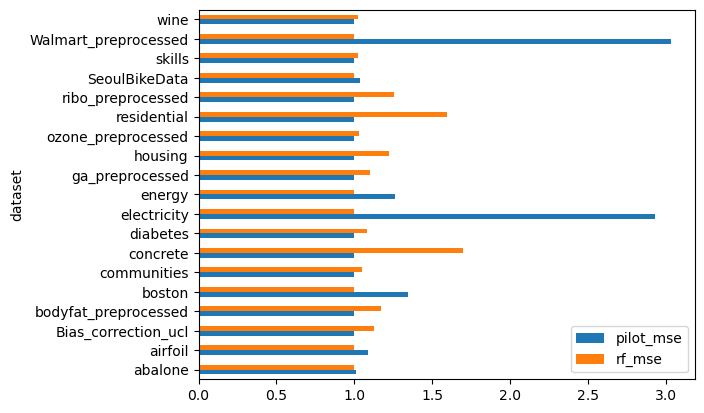

In [9]:
normalized_results = pd.DataFrame([{
    'dataset': d, 
    'pilot_mse': -np.nanmax(r['pilot']['mean_test_score']), 
    'rf_mse': -np.nanmax(r['rf']['mean_test_score'])
    } for d, r in results.items()]).set_index('dataset').apply(lambda row: row / row.min(), axis=1)

normalized_results.plot.barh()

In [18]:
normalized_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')


,pilot_mse,rf_mse
dataset,,
abalone,1.013,1.000
airfoil,1.088,1.000
Bias_correction_ucl,1.000,1.128
bodyfat_preprocessed,1.000,1.170
boston,1.347,1.000
communities,1.000,1.051
concrete,1.000,1.698
diabetes,1.000,1.082
electricity,2.930,1.000


### Deep dive max depth

In [138]:
max_depth_results = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_max_depth'])['mean_test_score'].mean().unstack()
max_depth_results *= -1
max_depth_results = max_depth_results.apply(lambda row: row / row.min(), axis=1)
max_depth_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_max_depth,2,10
dataset,,
Bias_correction_ucl,1.013,1.000
SeoulBikeData,2.423,1.000
Walmart_preprocessed,1.000,1.193
abalone,1.074,1.000
airfoil,1.642,1.000
bodyfat_preprocessed,1.022,1.000
boston,1.000,nan
communities,1.067,1.000
concrete,1.374,1.000


### Deep dive min samples split

In [141]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_sample_split'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_min_sample_split,2,10
dataset,,
Bias_correction_ucl,1.012,1.000
SeoulBikeData,1.000,1.024
Walmart_preprocessed,1.004,1.000
abalone,1.037,1.000
airfoil,1.000,1.003
bodyfat_preprocessed,1.008,1.000
boston,1.000,1.005
communities,1.032,1.000
concrete,1.000,1.001


### Deep dive max depth &  min samples split

In [143]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_sample_split', 'param_max_depth'])['mean_test_score'].mean().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

# Investigate bad performance

## Walmart

In [137]:
pd.read_csv(DATAPATH / 'Walmart_preprocessed.csv')

,Store,target,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,1
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,1
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,4,9,3
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,4,10,3
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,4,10,3
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,4,10,3


In [138]:
X[:5]

array([[  1.       ,   0.       ,  42.31     ,   2.572    , 211.0963582,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   1.       ,  38.51     ,   2.548    , 211.2421698,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  39.93     ,   2.514    , 211.2891429,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  46.63     ,   2.561    , 211.3196429,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  46.5      ,   2.625    , 211.3501429,
          8.106    ,   4.       ,   3.       ,   1.       ]])

In [139]:
X, y = datasets['Walmart_preprocessed']['data']
categorical = datasets['Walmart_preprocessed']['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

np.random.seed(101)
scores = cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error')
p_mse = -np.mean(scores)
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

2.7791366601220706 1.0


In [144]:
cv = KFold(5, shuffle=True)
scores = []
for train_idx, test_idx in cv.split(X):
    p = Pilot.PILOT()
    p.fit(X[train_idx, :], y[train_idx], categorical=np.array(categorical))
    scores.append(mean_squared_error(y[test_idx], p.predict(X[test_idx])))

[f'{m:.2e}' for m in scores]
    

['1.64e+10', '1.58e+10', '1.76e+10', '1.99e+10', '1.93e+10']

In [9]:
X_enc = OneHotEncoder().fit_transform(X[:, [0]]).toarray()
X_enc = np.hstack([X_enc, X[:, 1:]])
print(X.shape, X_enc.shape)

p2_mse = -np.mean(cross_val_score(d, X_enc, y, scoring='neg_mean_squared_error'))
d2_mse = -np.mean(cross_val_score(d, X_enc, y, scoring='neg_mean_squared_error'))
print(p_mse / min(p_mse, d_mse, d2_mse, p2_mse), p2_mse / min(p_mse, d_mse, d2_mse, p2_mse), d_mse / min(p_mse, d_mse, d2_mse, p2_mse), d2_mse / (min(p_mse, d_mse, d2_mse, p2_mse)))

(6435, 9) (6435, 53)
2.788660598687874 1.013677496545187 1.0 1.0136774965451865


In [10]:
f'{p_mse:.2e}, {p2_mse:.2e}, {d2_mse:.2e}'

'1.42e+12, 5.15e+11, 5.15e+11'

## Electricity

In [126]:
dname = 'electricity'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.786968927899247


In [17]:
results['electricity']['pilot']['mean_test_score'], results['electricity']['rf']['mean_test_score']

(array([-0.00049177, -0.00048808,         nan,         nan]),
 array([-0.0009364 , -0.00092756, -0.00016658, -0.00016975]))

In [50]:
pd.DataFrame(results['electricity']['pilot'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_sample_leaf,param_min_sample_split,param_n_estimators,param_n_features,param_truncation_factor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,454.748093,17.075063,5.613441,0.950244,2,1,2,50,1.0,1.5,"{'max_depth': 2, 'min_sample_leaf': 1, 'min_sa...",-0.000477,-0.000468,-0.000473,-0.000496,-0.000545,-0.000492,0.000028,2
1,469.487203,16.581230,6.039346,1.221317,2,1,10,50,1.0,1.5,"{'max_depth': 2, 'min_sample_leaf': 1, 'min_sa...",-0.000479,-0.000466,-0.000467,-0.000485,-0.000543,-0.000488,0.000028,1
2,4865.546804,2401.844961,2.852326,5.704651,10,1,2,50,1.0,1.5,"{'max_depth': 10, 'min_sample_leaf': 1, 'min_s...",NaN,-0.000134,NaN,NaN,NaN,NaN,NaN,3
3,6157.687217,6.942396,9.067408,4.538474,10,1,10,50,1.0,1.5,"{'max_depth': 10, 'min_sample_leaf': 1, 'min_s...",-0.000139,-0.000137,NaN,-0.000147,-0.000140,NaN,NaN,3


In [55]:
p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5)
p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
print(p_mse)

0.00017398152530192753


In [ ]:
prf = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5)
results = cross_validate(prf, X, y, scoring='neg_mean_squared_error', n_jobs=-1, fit_params={'categorical_idx': np.array(categorical)}, return_estimator=True)


In [129]:
p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5)
bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

p.model_tree.nodes_selected()

{'con': 3, 'lin': 21, 'blin': 6, 'pcon': 0, 'plin': 2}

In [41]:
p.print_tree(level=0)

                                                                                                        -->END 0.009
                                                                                                --> con (6, -1.0) 0.009 (0.0, -0.0) (0.0, 0.0)
                                                                                        --> plin (4, -1.385) 0.037 (0.036, 0.06) (0.031, 0.03)
                                                                                                        -->END 0.019
                                                                                                --> con (0, -1.0) 0.019 (0.0, 0.0) (0.0, 0.0)
                                                                                --> lin 2 0.043 (-0.005, 0.013) None
                                                                        --> lin 8 0.052 (-0.025, 0.015) None
                                                                --> blin (1, 2.523) 0.16 (0.009, -0.013) (-0.007

In [114]:
right_idx = X[bootstrap_idx, p.model_tree.pivot[0]] > p.model_tree.pivot[1]
X_remaining = X[bootstrap_idx, :][right_idx]
y_remaining = y[bootstrap_idx][right_idx]

In [115]:
y_pred = p.model_tree.lm_r[1] + p.model_tree.lm_r[0]*X_remaining[:, 2]

In [116]:
step2 = p.model_tree.right
step2.lm_l

y_pred = y_pred + step2.lm_l[1] + step2.lm_l[0]*X_remaining[:, step2.pivot[0]]

In [117]:
step3 = step2.left
step3.node

left_idx = X_remaining[:, step3.pivot[0]] <= step3.pivot[1]
X_remaining = X_remaining[left_idx, :]
y_remaining = y_remaining[left_idx]

y_pred = y_pred[left_idx] + step3.lm_l[1] + step3.lm_l[0]*X_remaining[:, step3.pivot[0]]

In [118]:
step4 = step3.left

left_idx = X_remaining[:, step4.pivot[0]] <= step4.pivot[1]
X_remaining = X_remaining[left_idx, :]
y_remaining = y_remaining[left_idx]

y_pred = y_pred[left_idx] + step4.lm_l[1] + step4.lm_l[0]*X_remaining[:, step4.pivot[0]]

In [119]:
step5 = step4.left

left_idx = X_remaining[:, step5.pivot[0]] <= step5.pivot[1]
X_remaining = X_remaining[left_idx, :]
y_remaining = y_remaining[left_idx]

y_pred = y_pred[left_idx] + step5.lm_l[1] + step5.lm_l[0]*X_remaining[:, step5.pivot[0]]

In [120]:
step6 = step5.left
y_pred = y_pred + step6.lm_l[1] + step6.lm_l[0]*X_remaining[:, step6.pivot[0]]


In [121]:
step7 = step6.left
y_pred = y_pred + step7.lm_l[1] + step7.lm_l[0]*X_remaining[:, step7.pivot[0]]

In [122]:
step8 = step7.left
y_pred = y_pred + step8.lm_l[1] + step8.lm_l[0]*X_remaining[:, step8.pivot[0]]

In [123]:
Rss_lin = np.sum((y_remaining - y_pred)**2)
Rss_lin

0.3722603405511866

In [124]:
step9 = step8.left
y_pred = y_pred + step9.lm_l[1] + step9.lm_l[0]*X_remaining[:, step9.pivot[0]]

In [125]:
num = y_remaining.shape[0]
k_lin = 2
k_con = 1
Rss_lin = np.sum((y_remaining - y_pred)**2)
Rss_con = np.sum((y_remaining - y_remaining.mean())**2)

BIC_lin = num * np.log(Rss_lin / num) + np.log(num) * k_lin
BIC_con = num * np.log(Rss_con / num) + np.log(num) * k_con

print(BIC_lin, BIC_con, Rss_lin)

-9715.990631592058 -7977.12227717116 0.3423860429184721


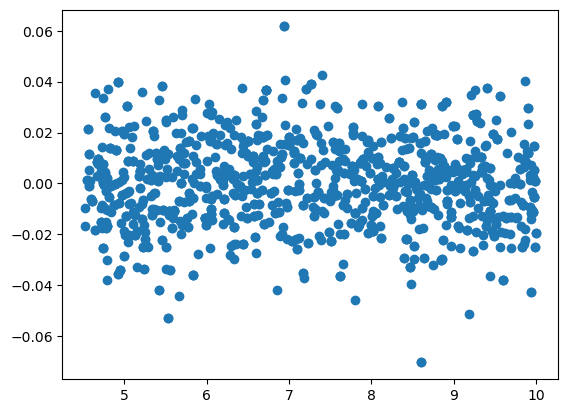

In [99]:
plt.scatter(X_remaining[:, step9.pivot[0]], (y_remaining - y_pred))

## Boston

In [34]:
dname = 'boston'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.1959726351852433


## Skills

In [35]:
dname = 'skills'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.4863177817216304


## Wine

In [36]:
dname = 'wine'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.3978899488124397


## Abalone

In [37]:
dname = 'abalone'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.2530548824414436


## Bike

In [41]:
dname = 'SeoulBikeData'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0587370965296532 1.0


In [42]:
datasets[dname]['categorical']

[-1]

## California

In [43]:
dname = 'housing'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.252993057125518
